In [41]:
import pandas as pd
import numpy as np
from tensorflow.python.ops import nn_ops, gen_nn_ops
import tensorflow as tf

In [255]:
class CNN_MC_dropout:
    def __init__(self, std=0.01, batch_size=64,width=500, height =1, input_channel=3, nb_classes=2, l_rate =1e-6,reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y = tf.placeholder(tf.float32, [None, self.nb_classes], name='y')
            self.x = tf.placeholder(tf.float32, [None, self.height,self.width,self.input_channel], name='x')
            self.keep_prob = tf.placeholder(tf.float32)
        
        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        self.dropout_bool = tf.cond(self.keep_prob < 1.0, lambda: tf.constant(1), lambda: tf.constant(0))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy = cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits)
        self.cost =tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.round(self.prediction),self.y)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.input = self.x
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.layers.conv2d(self.input, 128, [8,1], padding='SAME')
            self.batch1 = tf.layers.batch_normalization(self.conv1)
            self.relu1 = tf.nn.relu(self.batch1)
            self.dropout1 = tf.layers.dropout(self.relu1, self.keep_prob,self.dropout_bool)

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.layers.conv2d(self.dropout1, 256, [5,1], padding='SAME')
            self.batch2 = tf.layers.batch_normalization(self.conv2)
            self.relu2 = tf.nn.relu(self.batch2)
            self.dropout2 = tf.layers.dropout(self.relu2, self.keep_prob,self.dropout_bool)

        # Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.layers.conv2d(self.dropout2, 128, [3,1], padding='SAME')
            self.batch3 = tf.layers.batch_normalization(self.conv3)
            self.relu3 = tf.nn.relu(self.batch3)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            #Global Average Pooling
            self.GAP = tf.reduce_mean(self.relu3, axis=[1,2])# b,h,w,c
            self.logits = tf.layers.dense(self.GAP,self.nb_classes)
            self.prediction = tf.nn.softmax(self.logits)
            
        return self.logits


    def train(self, data, target, keep_prob,dropout_bool):
        opt, cost ,acc = self.sess.run((self.optimizer, self.cost, self.accuracy ), 
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.dropout_bool : dropout_bool})
        return cost,acc

    def test(self, data, target, keep_prob,dropout_bool):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.dropout_bool : dropout_bool})
        return cost,acc

    def get_last_conv_output(self, data, keep_prob):
        relu3 =  self.sess.run((self.relu3), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob})
        return relu3
    

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph() 

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [175]:
import os

In [176]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter = ',')
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

In [177]:
data_path ="/home/gin908/data/UCR_TS_Archive_2015"
fname = 'yoga'

In [178]:
full_data_path = os.path.join(data_path,fname)
if os.path.exists(full_data_path):
    x_train, y_train = readucr(full_data_path+'/'+fname+'_TRAIN')
    x_test, y_test = readucr(full_data_path+'/'+fname+'_TEST')
    nb_classes = len(np.unique(y_test))
    batch_size = min(int(x_train.shape[0]/10), 16)
    print ("batch size:{}".format(batch_size))

batch size:16


In [179]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(y_train)))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(y_test)))

In [180]:
trainX = x_train[:, np.newaxis, :, np.newaxis]
trainY = hot_encoded_y_train

validX =x_test[:len(x_test)//2, np.newaxis, :, np.newaxis]
validY= hot_encoded_y_test[:len(x_test)//2]

testX = x_test[len(x_test)//2:, np.newaxis, :, np.newaxis]
testY = hot_encoded_y_test[len(x_test)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testY shape:{}".format(testY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(300, 1, 426, 1)
trainY shape:(300, 2)
validX shape:(1500, 1, 426, 1)
validY shape:(1500, 2)
testY shape:(1500, 2)
testX shape:(1500, 1, 426, 1)
testY shape:(1500, 2)


왜 train 보다 test갯수가 10배가 많지?

In [228]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

# 2. Training condition 정의

In [229]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 50


std= 0.01
batch_size =128
l_rate = 1e-3

In [230]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [256]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

In [257]:
print (MC_dropout_model.input)
print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)

print ('[layer4]')
print (MC_dropout_model.GAP)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 426, 1), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 426, 128), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 426, 128), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 426, 128), dtype=float32)
Tensor("layer1/dropout/Identity:0", shape=(?, 1, 426, 128), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 426, 256), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 426, 256), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 426, 256), dtype=float32)
Tensor("layer2/dropout/Identity:0", shape=(?, 1, 426, 256), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 426, 128), dtype=float32)
Tensor("layer3/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 426, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 426, 128), dtype=float32)
[layer4]
Tensor("layer4/Mean:0", shape=(?, 128),

# 4. Training

In [258]:
import time

In [269]:
save_path = '/data2/gin/savedmodel'
model_name = 'ICML(UCR-'+fname+')_CNN_MCdropout'+str(keep_prob)+'_'+str(l_rate)+'_'+str(batch_size)
print (model_name)

ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128


In [259]:
def get_batch(X, Y,  batch_size=1024, shuffle=False):
    """
    dataset: numpy ndarray. dim=2
    
    dataset_input = normalized_data[:, input_idx]
    dataset_target = normalized_data[:, target_idx]
    interested_indices = train_indices
    """    
    assert np.isnan(X).any()==False
    assert np.isnan(Y).any()==False
    
    interested_indices = range(0,len(X))

    if shuffle:
        np.random.shuffle(interested_indices)
        
    for i in range(0, len(X)-batch_size, batch_size):
        batch_Xlist = []
        batch_Ylist = [] 
        
        batch_indices = interested_indices[i:i+batch_size]

        batch_Xlist.append(X[batch_indices])
        batch_Ylist.append(Y[batch_indices])

            
        batch_Xlist = np.asarray(batch_Xlist)
        batch_Xlist = batch_Xlist.reshape(-1,X.shape[1],X.shape[2],X.shape[3])
        
        batch_Ylist = np.asarray(batch_Ylist)
        batch_Ylist = batch_Ylist.reshape(-1,nb_classes)

        yield batch_Xlist, batch_Ylist

In [264]:
keep_prob =1.0

In [270]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,dropout_bool=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,dropout_bool=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/1.ckpt
  training loss:	0.692411
  training acc:	0.520
  validation loss:	0.691320
  validation acc:	0.529
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/2.ckpt
  training loss:	0.692261
  training acc:	0.520
  validation loss:	0.691297
  validation acc:	0.529
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/3.ckpt
  training loss:	0.692306
  training acc:	0.520
  validation loss:	0.691338
  validation 

Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/25.ckpt
  training loss:	0.690376
  training acc:	0.520
  validation loss:	0.689173
  validation acc:	0.529
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/26.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/26.ckpt
  training loss:	0.690146
  training acc:	0.520
  validation loss:	0.688905
  validation acc:	0.529
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/27.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/27.ckpt
  training loss:	0.689889
  training acc:	0.520
  validation loss:	0.688612
  validation acc:	0.529
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/28.ckpt is not in all_model_checkpoint_paths. Man

  training loss:	0.671899
  training acc:	0.594
  validation loss:	0.670190
  validation acc:	0.609
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/50.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/50.ckpt
  training loss:	0.670531
  training acc:	0.598
  validation loss:	0.668942
  validation acc:	0.612


In [271]:
train_history.to_csv(os.path.join(save_path, model_name, "history_train.csv"))
valid_history.to_csv(os.path.join(save_path, model_name, "history_valid.csv"))

# check the result

In [273]:
train_history = pd.read_csv(os.path.join(save_path, model_name, "history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path, model_name, "history_valid.csv"),index_col=0)

In [277]:
import matplotlib.pyplot as plt 

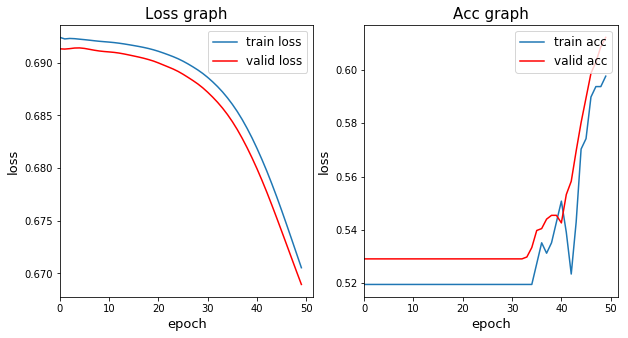

In [282]:
#Loss graph
%matplotlib inline

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train_history['loss'].tolist(), label='train loss')
ax.plot(valid_history['loss'].tolist(), label='valid loss', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Loss graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss', fontsize=13)

plt.savefig(os.path.join(save_path, model_name, 'loss_graph.png'))

ax = fig.add_subplot(1,2,2)
ax.plot(train_history['acc'].tolist(), label='train acc')
ax.plot(valid_history['acc'].tolist(), label='valid acc', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Acc graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss', fontsize=13)


plt.savefig(os.path.join(save_path, model_name, 'acc_graph.png'))


In [289]:
bestepoch = int(np.argmin(valid_history['loss']))

In [297]:
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

error: 0.6689424027096141


In [298]:
bestepoch=bestepoch
MC_dropout_model.load(os.path.join(save_path, model_name,str(bestepoch)+'.ckpt'))

INFO:tensorflow:Restoring parameters from /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout1.0_0.001_128/49.ckpt
Model restored


# 5. Trained 된 모델에서 Last Conv output Load하기

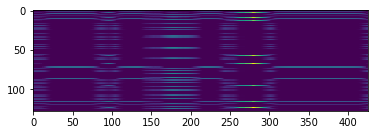

In [315]:
#각 한줄당 last conv-layer의 한 채널
plt.imshow(MC_dropout_model.get_last_conv_output(data=train_in,keep_prob=0.5)[0][0].T)

In [ ]:
# prediction 시에는 MC dropout 을 적용
# keep_prob = 0.5(survive 확률) , dropout_bool=True

#각 데이터 마다 MC dropout 을 B 번 적용한다면, B 개의 서로 다른 model structure를 거치며 나타난 last conv output을 각 노드마다 모두 저장해놓음

#예를들어, unit 1이 보는 pattern을 모두 last_conv_patter1에 저장
#데이터가 N 개이고, MC dropout 횟수가 B번이라면, 총 N*B개의 패턴이 저장됨
last_conv_pattern1=[]
B = MCdropout횟수

for batch in getbatch(X,Y):
    for i in range(0,B):
        output = MC_dropout_model.get_last_conv_output(data=train_in,target= train_target,keep_prob=0.5,dropout_bool=True)
        pattern = output[output>threshold]
        last_conv_pattern1.append(pattern)

# 6. pattern 저장해 놓은 것을 clustering 해서 라벨 붙혀주기?

# 7. 각 노드당 pattern의 entropy 계산하여 uncertainty 계산?

# 8. uncertainty 가 특정 threshold보다 낮을 경우, pattern과 unit 매칭